<img src="../../data/images/gempy_logo.png" />

# <center> From Maps to Models - Tutorials for structural geological modeling using GemPy and GemGIS</center>


# Example 3 - Unconformable Dipping Layers
This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 1134 m wide (W-E extent) and 788 m high (N-S extent). The vertical model extents varies between 0 m and 600 m. The model represents two unconformable dipping planar stratigraphic units (blue and red) above an unspecified basement (yellow). 

<div class="alert alert-block alert-success">
<b>In this tutorial, you will learn the following:</b> <br>
- How to build your 12th GemPy model with input data generated through GemGIS<br>
- How to create models consisting of unconformable layers
</div>


## Your Tasks


1. Georeference the map in QGIS given the dimensions above using the coordinate reference system with the EPSG code 4326
2. Digitize the layer boundaries (including a `formation` column) and the topographic lines (including a `Z` column)
3. Digitize so-called strike lines for the different layers. The orientations used for `GemPy` will be calculated from the strike lines.

## Contents

1. [Installing GemPy and GemGIS](#installing-gempy)
2. [Importing Libraries](#importing-libraries)
3. [Data Preparation](#data-preparation)
    1. [Creating Digital Elevation Model from Contour lines](#creating-digital-elevation-model-from-contour-lines)
        1. [Loading Contour Lines](#loading-contour-lines)
        2. [Plotting Contour Lines](#plotting-contour-lines)
        3. [Interpolating Contour Lines](#interpolating-contour-lines)
        4. [Plotting the raster](#plotting-the-raster)
        5. [Saving the raster to disc](#saving-the-raster-to-disc)
        6. [Opening raster](#opening-raster)
    2. [Processing Stratigraphic Boundaries](#processing-stratigraphic-boundaries)
        1. [Opening Stratigraphic Boundaries](#opening-stratigraphic-boundaries)
        2. [Plotting Stratigraphic Boundaries](#plotting-stratigraphic-boundaries)
        3. [Extracting Z coordinates from Digital Elevation Model](#extracting-z-coordinates-from-digital-elevation-model)
        4. [Plotting the Interface Points](#plotting-the-interface-points)
    3. [Processing Orientations](#processing-orientations)
        1. [Orientations from Strike Lines](#orientations-from-strike-lines)
        2. [Plotting Strike Lines](#plotting-strike-lines)
        2. [Loading Strike Lines](#loading-strike-lines)
        3. [Plotting Strike Lines](#plotting-strike-lines)
        4. [Calculate Orientations for each formation](#calculate-orientations-for-each-formation)
        5. [Merging Orientations for GemPy](#merging-orientations-for-gempy)
        6. [Plotting Orientations](#plotting-orientations)
4. [GemPy Model calculation](#gempy-model-calculation)
    1. [Creating the GemPy Model](#creating-the-gempy-model)
    2. [Data Initiation](#data-initiation)
    3. [Inspecting the Surfaces](#inspecting-the-surfaces)
    4. [Inspecting the Input Data](#inspecting-the-input-data)
    5. [Map Stack to Surfaces](#map-stack-to-surfaces)
    6. [Showing the Number of Data Points](#showing-the-number-of-data-points)
    7. [Loading Digital Elevation Model](#loading-digital-elevation-model)
    8. [Defining Custom Section](#defining-custom-section)
    6. [Plotting Input Data in 2D](#plotting-the-input-data-in-2d)
    7. [Plotting Input Data in 3D](#plotting-the-input-data-in-3d)
    8. [Setting the Interpolator](#setting-the-interpolator)
    9. [Computing the Model](#computing-the-model)
5. [Model Visualization and Post-Processing](#model-visualization-and-post-processing)
    1. [Visualizing the computed model in 2D](#visualizing-the-computed-model-in-2d)
    2. [Visualizing the computed model in 3D](#visualizing-the-computed-model-in-3d)    
   

<img src="../../data/images/example29/cover_example29.png" />
Source: Powell, D. (1995): Interpretation geologischer Strukturen durch Karten - Eine praktische Anleitung mit Aufgaben und Lösungen, page 40, figure 34, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-3-540-58607-4.


<a id='installing-gempy'></a>

# Installing GemPy and GemGIS

If you have not installed `GemPy` yet, please follow the [GemPy installation instructions](https://docs.gempy.org/installation.html) and the [GemGIS installation instructions](https://gemgis.readthedocs.io/en/latest/getting_started/installation.html). If you encounter any issues, feel free to open a new discussion at [GemPy Discussions](https://github.com/cgre-aachen/gempy/discussions) or [GemGIS Discussions](https://github.com/cgre-aachen/gemgis/discussions). If you encounter an error in the installation process, feel free to also open an issue at [GemPy Issues](https://github.com/cgre-aachen/gempy/issues) or [GemGIS Issues](https://github.com/cgre-aachen/gemgis/issues). There, the `GemPy` and `GemGIS` development teams will help you out. 

<a id='importing-libraries'></a>

# Importing Libraries

For this notebook, we need the `geopandas` library for the data preparation, `rasterio` for dealing with the created digital elevation model, `matplotlib` for plotting, `numpy` for some numerical calculations, `pandas` for manipulating `DataFrames` and of course the `gempy` and `gemgis` libraries. Any warnings that may appear can be ignored for now. The file path is set to load the data provided for this tutorial. 

In [1]:
import geopandas as gpd
import rasterio
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg
import matplotlib.pyplot as plt
import numpy as np
import gempy as gp
import pyvista as pv
import pandas as pd

C:\Users\ale93371\AppData\Local\Temp\ipykernel_18872\547675048.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementatio

In [2]:
file_path = '../../data/example29_unconformable_layers/'

<a id='data-preparation'></a>
# Data Preparation

At his point, you should have the topographic contour lines (including a `Z` column) and the layer boundaries (including a `formation` column) digitized. If not, please generate the data before continuing with this tutorial. 

<a id='creating-digital-elevation-model-from-contour-lines'></a>
## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating the contour lines digitized from the georeferenced map using the `SciPy` [Radial Basis Function interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 


<img src="../../data/images/example29/dem_example29.png" width=700/>
Source: Powell, D. (1995): Interpretation geologischer Strukturen durch Karten - Eine praktische Anleitung mit Aufgaben und Lösungen, page 40, figure 34, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-3-540-58607-4.


<a id='loading-contour-lines'></a>
### Loading contour lines

First, the contour lines are loaded using `GeoPandas`. Please provide here the name of your shape file containing the digitized topographic contour lines. 

In [3]:
topo = gpd.read_file(file_path + 'topo29.shp')
topo['Z'] = topo['Z']*0.444
topo.head()

,id,Z,geometry
0,None,222.00,"LINESTRING (2.57796 40.09902, 33.28214 34.2506..."
1,None,177.60,"LINESTRING (4.77111 101.99475, 41.32371 85.911..."
2,None,88.80,"LINESTRING (1.60322 344.21664, 17.19899 324.23..."
3,None,133.20,"LINESTRING (3.06532 159.01680, 29.13951 156.57..."
4,None,88.80,"LINESTRING (1026.29441 2.32800, 1000.22022 20...."


<a id='plotting-contour-lines'></a>

### Plotting the contour lines

The contour lines are plotted using the built-in plotting function of `GeoPandas`. 

<AxesSubplot: >

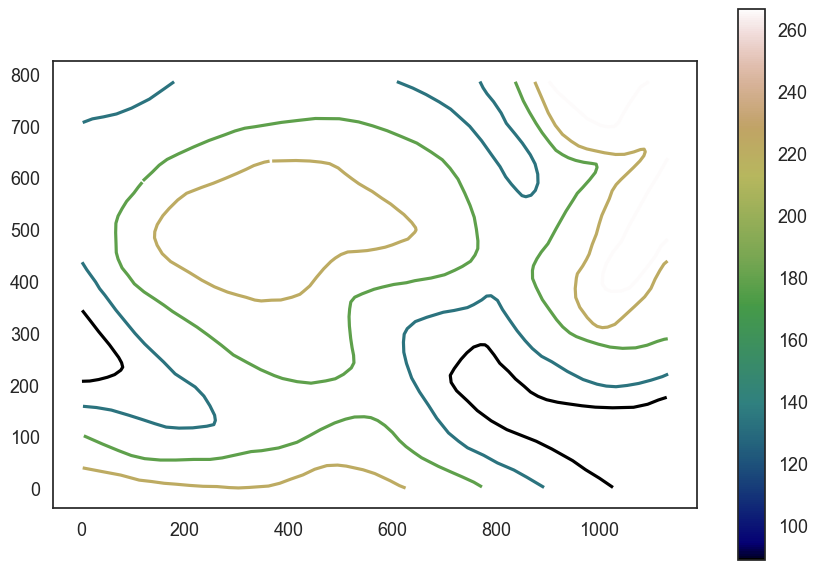

In [4]:
topo.plot(column='Z', aspect=1, legend=True, cmap='gist_earth')

<a id='interpolating-contour-lines'></a>

### Interpolating the contour lines

The digital elevation model (DEM) will be created by interpolating the contour lines digitized from the georeferenced map using the `SciPy` [Radial Basis Function interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

There is also a [tutorial available for this task on the GemGIS Documentation page](https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/05_interpolating_rasters.html).

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=5)

<a id='plotting-the-raster'></a>

### Plotting the raster

The interpolated digital elevation model can be displayed using `matplotlib` and its `plt.imshow()` function and by providing the extent of the raster to align it with the contour lines. 

(0.0, 788.0)

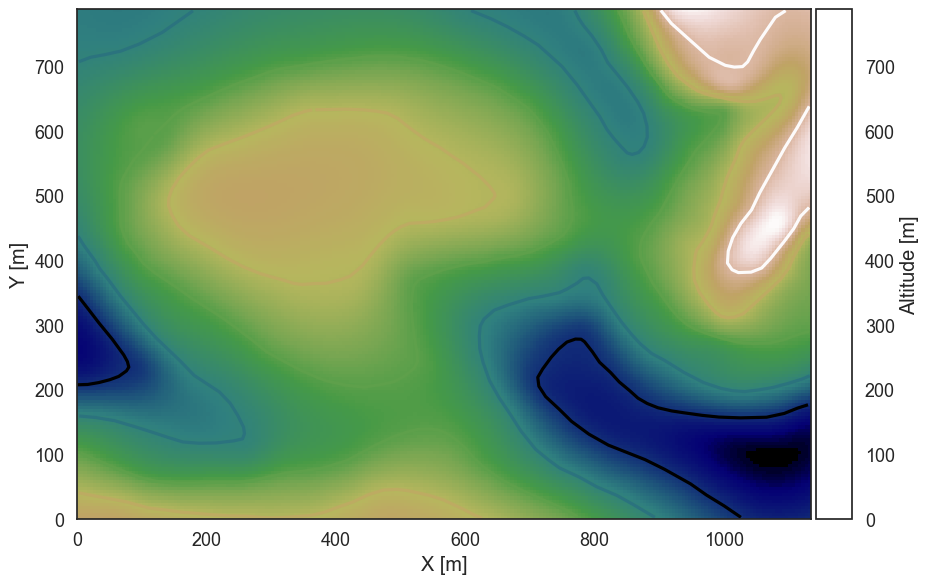

In [6]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(10, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = ax.imshow(topo_raster, origin='lower', extent=[0, 1134, 0, 788], cmap='gist_earth')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
plt.xlim(0, 1134)
plt.ylim(0, 788)

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster29.tif')

<a id='processing-stratigraphic-boundaries'></a>

## Processing Stratigraphic Boundaries

The interface points will be extracted from LineStrings digitized from the georeferenced map using QGIS. It is important to provide a `formation` name for each layer boundary. Up until now, only the `X` and `Y` position are stored in the vertices of the LineStrings. Using the digital elevation model created already, we will now sample the elevation model at the locations of the vertices to extract the height at this point as the stratigraphic boundary was mapped at the surface.

<img src="../../data/images/example29/interfaces_example29.png" width=700/>
Source: Powell, D. (1995): Interpretation geologischer Strukturen durch Karten - Eine praktische Anleitung mit Aufgaben und Lösungen, page 40, figure 34, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-3-540-58607-4.

<a id='opening-stratigraphic-boundaries'></a>

### Opening Stratigraphic Boundaries

The stratigraphic units are opened using `GeoPandas`.

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces29.shp')
interfaces.head()

,id,formation,geometry
0,None,Limestone,"LINESTRING (1.72506 128.31262, 28.28662 113.69..."
1,None,Limestone,"LINESTRING (58.01606 561.33908, 78.11999 572.0..."
2,None,Sandstone,"LINESTRING (65.69211 416.83447, 81.04420 391.6..."
3,None,Sandstone,"LINESTRING (563.66035 585.09826, 588.75980 575..."
4,None,Limestone,"LINESTRING (888.97848 785.65019, 900.18794 764..."


<a id='plotting-stratigraphic-boundaries'></a>

### Plotting Stratigraphic Boundaries

Text(14.305555555555559, 0.5, 'Y [m]')

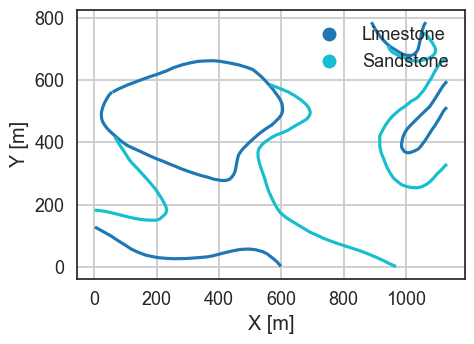

In [9]:
fig, ax = plt.subplots(1, figsize=(5,5))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')

plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

<a id='extracting-z-coordinates-from-digital-elevation-model'></a>

### Extracting Z coordinates from Digital Elevation Model

The vertical position of the interface point will be extracted from the digital elevation model using the `GemGIS` function `gg.vector.extract_xyz()`. The resulting GeoDataFrame now contains single points including the information about the respective `formation` as well as the `X`, `Y`, and `Z` location. This is all we need as preparational steps to generate input data for `GemPy`. 

There is also a [tutorial available for this task on the GemGIS Documentation page](https://gemgis.readthedocs.io/en/latest/getting_started/tutorial/02_extract_xyz.html).

In [10]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=topo_raster)
interfaces_coords

,formation,geometry,X,Y,Z
0,Limestone,POINT (1.72506 128.31262),1.73,128.31,161.10
1,Limestone,POINT (28.28662 113.69158),28.29,113.69,166.12
2,Limestone,POINT (53.87344 99.31423),53.87,99.31,167.68
3,Limestone,POINT (77.51078 83.47477),77.51,83.47,170.08
4,Limestone,POINT (96.51813 72.02162),96.52,72.02,171.47
...,...,...,...,...,...
300,Sandstone,POINT (1089.77409 287.31643),1089.77,287.32,181.40
301,Sandstone,POINT (1099.52145 299.25694),1099.52,299.26,184.35
302,Sandstone,POINT (1111.46196 309.97904),1111.46,309.98,185.01
303,Sandstone,POINT (1123.64616 323.38166),1123.65,323.38,185.75


<a id='plotting-the-interface-points'></a>

### Plotting the Interface Points

The interface points incuding their altitude (Z-) values and the digitized LineString can be plotted using `matplotlib`. 

(0.0, 788.0)

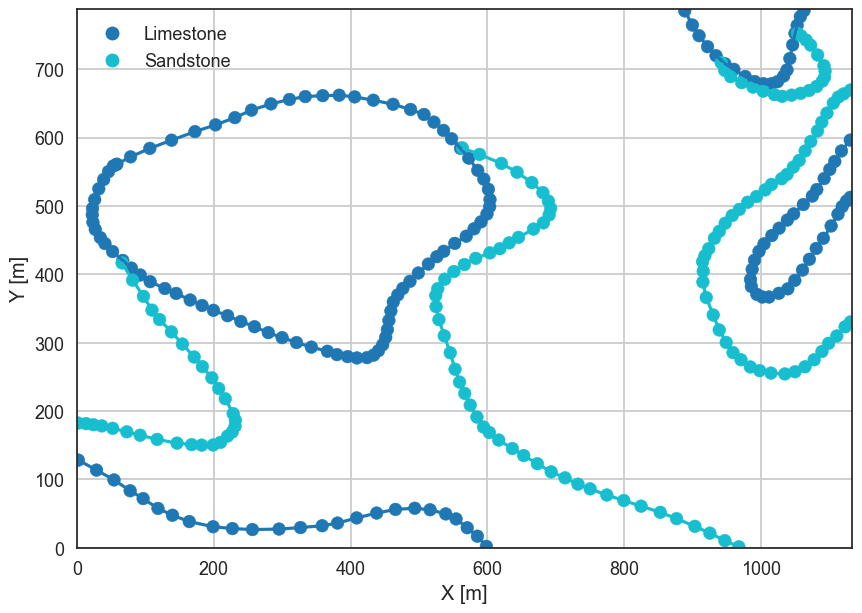

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0, 1134)
plt.ylim(0, 788)

<a id='processing-orientations'></a>

## Processing Orientations

For this example, orientations must be calculated yourself. They will be calculated using functions implemented in GemGIS and the previously digitized strike lines. 

<img src="../../data/images/example29/orientations_example29.png" width=700/>
Source: Powell, D. (1995): Interpretation geologischer Strukturen durch Karten - Eine praktische Anleitung mit Aufgaben und Lösungen, page 40, figure 34, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-3-540-58607-4.

<a id='orientations-strike-lines'></a>
### Orientations from Strike Lines

Strike lines connect outcropping stratigraphic boundaries (interfaces) of the same altitude. In other words: the intersections between topographic contours and stratigraphic boundaries at the surface. The height difference and the horizontal difference between two digitized lines is used to calculate the dip and azimuth and hence an orientation that is necessary for `GemPy`.

The calculation of orientations from strike lines has been implemented into `GemPy` for simple cases like these. In order to calculate the orientations, each set of strikes lines/LineStrings for one formation must be given an id number next to the altitude of the strike line. The id field is already predefined in QGIS. The strike line with the lowest altitude gets the id number `1`, the strike line with the highest altitude the the number according to the number of digitized strike lines. It is currently recommended to use one set of strike lines for each structural element of one formation as illustrated. 

<img src="../../data/images/fig3.png" width=500/>

By CrunchyRocks, after Karla Panchuck - https://openpress.usask.ca/physicalgeology/chapter/13-5-measuring-geological-structures/, CC BY 4.0, https://commons.wikimedia.org/w/index.php?curid=113554289


<img src="../../data/images/model1_strike_lines.png" width=500/>
Source: Powell, D. (1995): Interpretation geologischer Strukturen durch Karten - Eine praktische Anleitung mit Aufgaben und Lösungen, page 14, figure 8, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-3-540-58607-4.

In [12]:
strikes = gpd.read_file(file_path + 'strikes29.shp')
strikes['Z'] = strikes['Z']*0.444
strikes

,id,formation,Z,geometry
0,2,Limestone1,222.00,"LINESTRING (583.88612 556.09987, 583.64243 468..."
1,1,Limestone1,177.60,"LINESTRING (113.81970 587.53510, 114.06338 385..."
2,1,Sandstone,133.20,"LINESTRING (231.03170 183.50705, 721.08021 98...."
3,2,Sandstone,177.60,"LINESTRING (1073.93463 271.96433, 16.34610 453..."
4,1,Limestone2,177.60,"LINESTRING (114.06338 385.52107, 115.64733 58...."
5,2,Limestone2,222.00,"LINESTRING (584.00796 468.25179, 583.03322 21...."
6,3,Limestone1,266.40,"LINESTRING (1041.89018 715.83473, 1046.76386 3..."


<a id='calculate-orientations-for-each-formation'></a>

### Calculate Orientations for each formation

The calculations will be calculated using the function `gg.vector.calculate_orientations_from_strike_lines()` where the strike lines for each single formation will be provided and calculated separately. The result is a `GeoDataFrame` ready to be used in `GemPy`.

In [13]:
orientations_limestone1 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Limestone1'].sort_values(by='id', ascending=True).reset_index())
orientations_limestone1

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,5.40,269.97,199.80,POINT (348.85291 499.50426),1.00,Limestone1,348.85,499.50
1,5.51,269.22,244.20,POINT (814.04565 531.00042),1.00,Limestone1,814.05,531.00


In [14]:
orientations_limestone2 = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Limestone2'].sort_values(by='id', ascending=True).reset_index())
orientations_limestone2

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,5.43,269.98,199.80,POINT (349.18797 233.49272),1.00,Limestone2,349.19,233.49


In [15]:
orientations_sandstone = gg.vector.calculate_orientations_from_strike_lines(gdf=strikes[strikes['formation'] == 'Sandstone'].sort_values(by='id', ascending=True).reset_index())
orientations_sandstone

,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,10.94,189.75,155.40,POINT (510.59816 251.79948),1.00,Sandstone,510.60,251.80


<a id='merging-orientations-for-gempy'></a>

### Merging Orientations for GemPy

Since `GemPy` only takes one `DataFrame` for the necessary orientations, the single `DataFrames` are concatenated using `pd.concat()`. 

In [16]:
import pandas as pd
orientations = pd.concat([orientations_limestone1, orientations_limestone2, orientations_sandstone]).reset_index()
orientations['formation'] = ['Limestone', 'Limestone', 'Limestone', 'Sandstone']

orientations

,index,dip,azimuth,Z,geometry,polarity,formation,X,Y
0,0,5.40,269.97,199.80,POINT (348.85291 499.50426),1.00,Limestone,348.85,499.50
1,1,5.51,269.22,244.20,POINT (814.04565 531.00042),1.00,Limestone,814.05,531.00
2,0,5.43,269.98,199.80,POINT (349.18797 233.49272),1.00,Limestone,349.19,233.49
3,0,10.94,189.75,155.40,POINT (510.59816 251.79948),1.00,Sandstone,510.60,251.80


<a id='plotting-the-orientations'></a>

### Plotting the Orientations

The orientations can be plotted using `matplotlib`.

(0.0, 788.0)

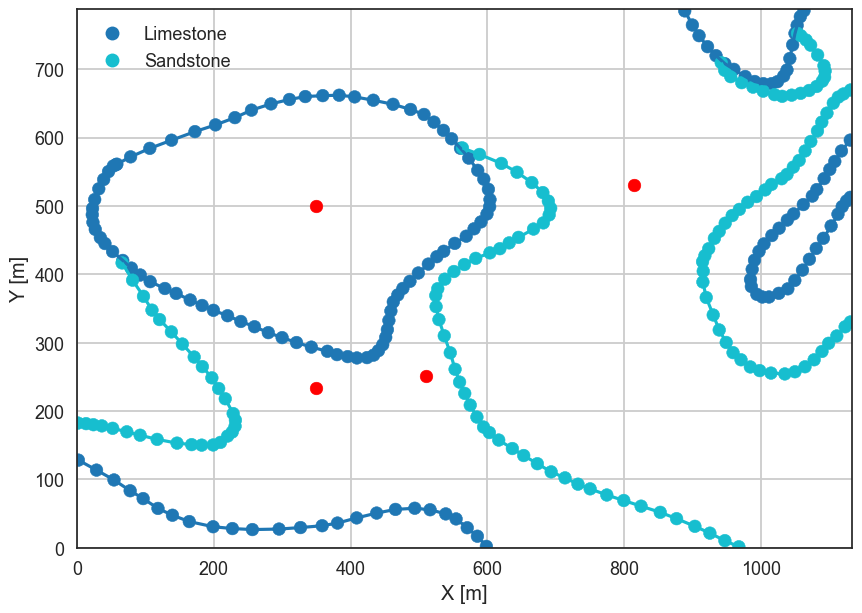

In [17]:
fig, ax = plt.subplots(1, figsize=(10, 10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.xlim(0, 1134)
plt.ylim(0, 788)

<a id='gempy-model-calculation'></a>

# GemPy Model Calculation


The creation of a `GemPy` Model follows particular steps which will be performed in the following:

1. Create new model: `gp.create_model()`
2. Data Initiation: `gp.init_data()`
3. Map Stack to Surfaces: `gp.map_stack_to_surfaces()`
4. [...]
5. Set the Interpolator: `gp.set_interpolator()`
6. Computing the Model: `gp.compute_model()`

<a id='creating-the-gempy-model'></a>

## Creating the GemPy Model

The first step is to create a new empty `GemPy` model by providing a name for it. 

In [18]:
geo_model = gp.create_model('Model29')
geo_model

Model29  2023-03-05 15:03

<a id='data-initiation'></a>

## Data Initiation

During this step, the `extent` of the model (`xmin`, `xmax`, `ymin`, `ymax`, `zmin`, `zmax`) and the `resolution` in `X`, `Y`and `Z` direction (`res_x`, `res_y`, `res_z`, equal to the number of cells in each direction) will be set using lists of values. 

The interface points (`surface_points_df`) and orientations (`orientations_df`) will be passed as `pandas` `DataFrames`. 

In [19]:
gp.init_data(geo_model, [0, 1134, 0, 788, 0, 600], [50,50,50],
             surface_points_df=interfaces_coords,
             orientations_df=orientations,
             default_values=True)

Active grids: ['regular']


Model29  2023-03-05 15:03

<a id='inspecting-the-surfaces'></a>

## Inspecting the Surfaces

The model consists of five different layers or surfaces now which all belong to the `Default series`. During the next step, the proper `Series` will be assigned to the surfaces. Using the `surfaces`-attribute again, we can check which layers were loaded.

In [20]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Limestone,Default series,1,#015482,1
1,Sandstone,Default series,2,#9f0052,2


<a id='inspecting-the-input-data'></a>

## Inspecting the Input Data

The loaded interface points and orientations can again be inspected using the `surface_points`- and `orientations`-attributes. Using the `df`-attribute of this object will convert the displayed table in a `pandas` `DataFrame`.

In [21]:
geo_model.surface_points.df.head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
0,1.73,128.31,161.10,0.25,0.38,0.48,Limestone,Default series,1,1,0.00
1,28.29,113.69,166.12,0.26,0.38,0.49,Limestone,Default series,1,1,0.00
2,53.87,99.31,167.68,0.27,0.37,0.49,Limestone,Default series,1,1,0.00
3,77.51,83.47,170.08,0.28,0.36,0.49,Limestone,Default series,1,1,0.00
4,96.52,72.02,171.47,0.29,0.36,0.49,Limestone,Default series,1,1,0.00


In [22]:
geo_model.orientations.df.head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
0,348.85,499.50,199.80,0.40,0.55,0.50,-0.09,-0.00,1.00,5.40,269.97,1.00,Limestone,Default series,1,1,0.01
1,814.05,531.00,244.20,0.61,0.56,0.52,-0.10,-0.00,1.00,5.51,269.22,1.00,Limestone,Default series,1,1,0.01
2,349.19,233.49,199.80,0.40,0.43,0.50,-0.09,-0.00,1.00,5.43,269.98,1.00,Limestone,Default series,1,1,0.01
3,510.60,251.80,155.40,0.48,0.44,0.48,-0.03,-0.19,0.98,10.94,189.75,1.00,Sandstone,Default series,2,1,0.01


<a id='map-stack-to-surfaces'></a>

## Map Stack to Surfaces

During this step, all the layers of the model are assigned to the `Strata1` and `Strata2` series. This is because the layers are laying unconformable on top of each other. We will also add a `Basement` here (`geo_model.add_surfaces('Basement')`). 

In [23]:
gp.map_stack_to_surfaces(geo_model,
                         {'Strata1': ('Limestone'),
                          'Strata2': ('Sandstone')
                          },
                         remove_unused_series=True)
geo_model.add_surfaces('Claystone')

,surface,series,order_surfaces,color,id
0,Limestone,Strata1,1,#015482,1
1,Sandstone,Strata2,1,#9f0052,2
2,Claystone,Strata2,2,#ffbe00,3


### Adding additional Orientations

Additional orientations are needed to better constrain the model. They are added manual here. 

In [24]:
geo_model.add_orientations(X=50, Y=600, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=50, Y=700, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=50, Y=800, Z=300, surface='Limestone', orientation = [270,5.5,1])

geo_model.add_orientations(X=100, Y=200, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=100, Y=400, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=100, Y=600, Z=300, surface='Limestone', orientation = [270,5.5,1])

geo_model.add_orientations(X=200, Y=200, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=200, Y=400, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=200, Y=600, Z=300, surface='Limestone', orientation = [270,5.5,1])

geo_model.add_orientations(X=600, Y=200, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=600, Y=400, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=600, Y=600, Z=300, surface='Limestone', orientation = [270,5.5,1])

geo_model.add_orientations(X=1000, Y=200, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=1000, Y=400, Z=300, surface='Limestone', orientation = [270,5.5,1])
geo_model.add_orientations(X=1000, Y=600, Z=300, surface='Limestone', orientation = [270,5.5,1])

geo_model.add_orientations(X=200, Y=200, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=200, Y=400, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=200, Y=600, Z=300, surface='Sandstone', orientation = [190,11,1])

geo_model.add_orientations(X=600, Y=200, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=600, Y=400, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=600, Y=600, Z=300, surface='Sandstone', orientation = [190,11,1])

geo_model.add_orientations(X=1000, Y=200, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=1000, Y=400, Z=300, surface='Sandstone', orientation = [190,11,1])
geo_model.add_orientations(X=1000, Y=600, Z=300, surface='Sandstone', orientation = [190,11,1])



,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,348.85,499.50,199.80,-0.09,-0.00,1.00,0.01,Limestone
1,814.05,531.00,244.20,-0.10,-0.00,1.00,0.01,Limestone
2,349.19,233.49,199.80,-0.09,-0.00,1.00,0.01,Limestone
4,50.00,600.00,300.00,-0.10,0.00,1.00,0.01,Limestone
5,50.00,700.00,300.00,-0.10,0.00,1.00,0.01,Limestone
6,50.00,800.00,300.00,-0.10,0.00,1.00,0.01,Limestone
7,100.00,200.00,300.00,-0.10,0.00,1.00,0.01,Limestone
8,100.00,400.00,300.00,-0.10,0.00,1.00,0.01,Limestone
9,100.00,600.00,300.00,-0.10,0.00,1.00,0.01,Limestone
10,200.00,200.00,300.00,-0.10,0.00,1.00,0.01,Limestone


<a id='showing-the-number-of-data-points'></a>

## Showing the Number of Data Points

You can also return the number of interfaces and orientations for each formation using `gg.utils.show_number_of_data_points()`

In [25]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,Limestone,Strata1,1,False,False,True,True,#015482,NaN,NaN,NaN,1,160,18
1,Sandstone,Strata2,1,False,False,True,True,#9f0052,NaN,NaN,NaN,2,145,10
2,Claystone,Strata2,2,True,False,True,True,#ffbe00,NaN,NaN,NaN,3,0,0


<a id='loading-digital-elevation-model'></a>

## Loading Digital Elevation Model

`GemPy` is capable of including a topography into the modeling process. Here, we use the topography that we have interpolated in one of the previous steps. `GemPy` takes the file path of the raster/digital elevation model and loads it as grid into the `geo_model` object.

In [26]:
geo_model.set_topography(source='gdal', filepath=file_path + 'raster29.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  11.34      ,    7.88      ,    6.        ],
       [  11.34      ,    7.88      ,   18.        ],
       [  11.34      ,    7.88      ,   30.        ],
       ...,
       [1131.50220264,  775.53164557,  266.35290527],
       [1131.50220264,  780.51898734,  267.26382446],
       [1131.50220264,  785.50632911,  268.18728638]])

<a id='plotting-the-input-data-in-2d'></a>

## Plotting the input data in 2D using Matplotlib

The input data can now be visualized in 2D using `matplotlib`. This might for example be useful to check if all points and measurements are defined the way we want them to. Using the function `plot_2d()`, we attain a 2D projection of our data points onto a plane of chosen direction (we can choose this attribute to be either `'x'`, `'y'`, or `'z'`).

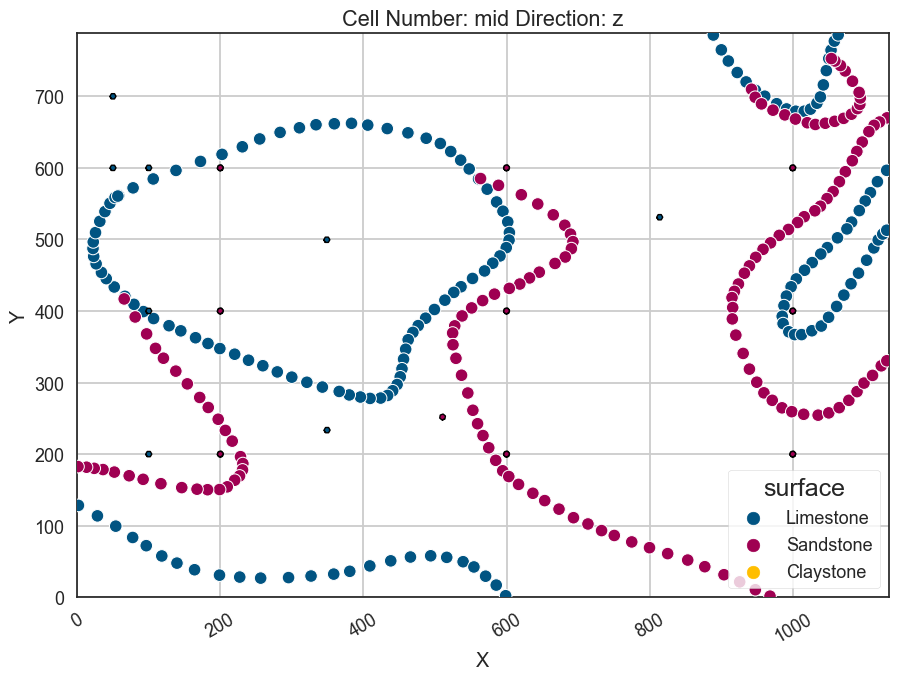

In [27]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

<a id='plotting-the-input-data-in-3d'></a>

## Plotting the input data in 3D using PyVista

The input data can also be viszualized using the `pyvista` package. In this view, the interface points are visible as well as the orientations (marked as arrows) which indicate the normals of each orientation value. 

The `pyvista` package requires the Visualization Toolkit (VTK) to be installed.

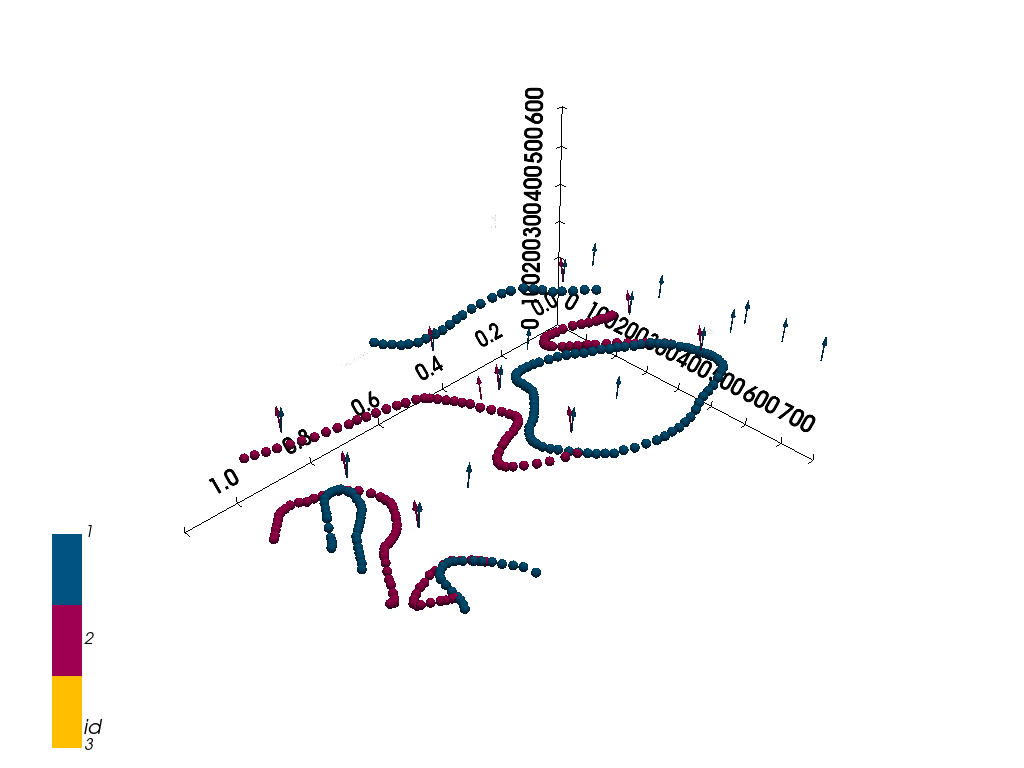

In [28]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

<a id='setting-the-interpolator'></a>
## Setting the interpolator

Once we have made sure that we have defined all our primary information, we can continue with the next step towards creating our geological model: preparing the input data for interpolation.

Setting the interpolator is necessary before computing the actual model. Here, the most important kriging parameters can be defined. 


In [29]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging=False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1505.62
$C_o$           53973.81
drift equations   [3, 3]


<a id='computing-the-model'></a>

## Computing the model

At this point, we have all we need to compute our full model via `gp.compute_model()`. By default, this will return two separate solutions in the form of arrays. The first provides information on the lithological formations, the second on the fault network in the model, which is not present in this example. 

In [30]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [31]:
sol


Lithology ids 
  [3. 2. 2. ... 1. 1. 1.] 

In [32]:
geo_model.solutions


Lithology ids 
  [3. 2. 2. ... 1. 1. 1.] 

<a id='model-visualization-and-post-processing'></a>

# Model Visualization and Post-Processing

<a id='visualizing-cross-sections-of-the-computed-model'></a>

## Visulazing Cross Sections of the computed model

Cross sections in different `direction`s and at different `cell_number`s can be displayed. Here, we see the horizontal layers in the one direction and the faulted layers in the other direction.

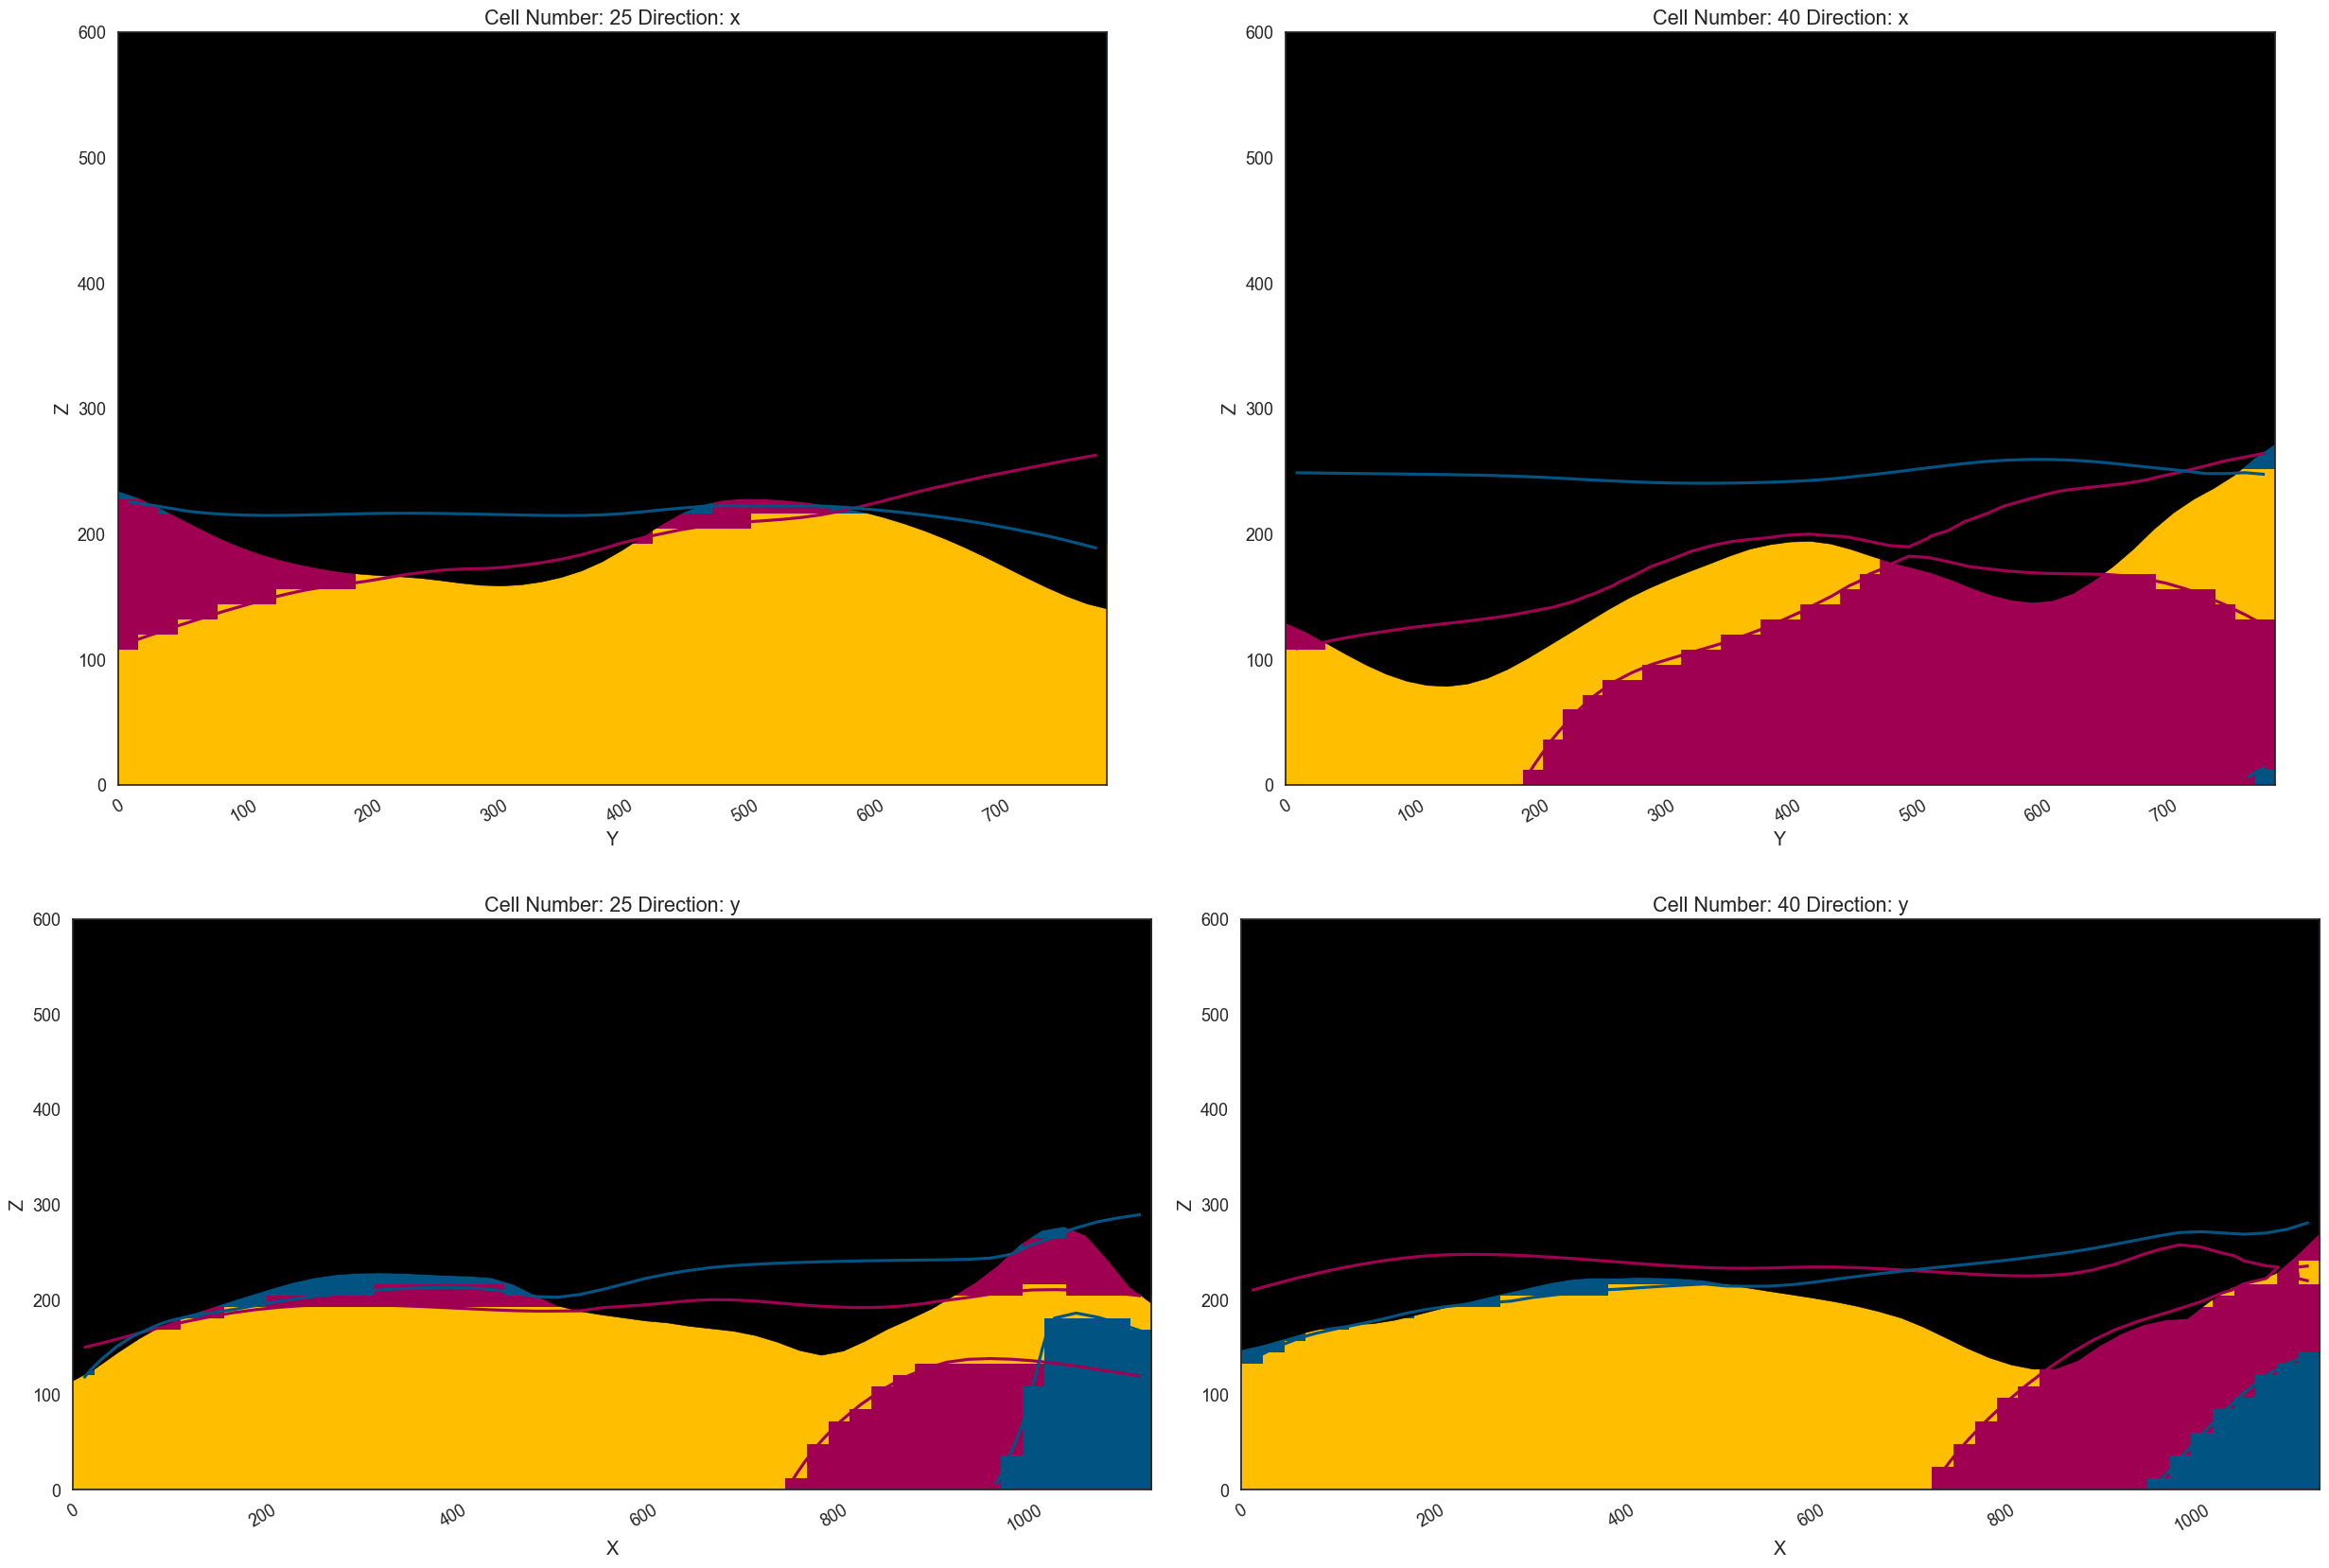

In [33]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 40, 25, 40], show_topography=True, show_data=False)

Next to the lithology data, we can also plot the calculated scalar field.

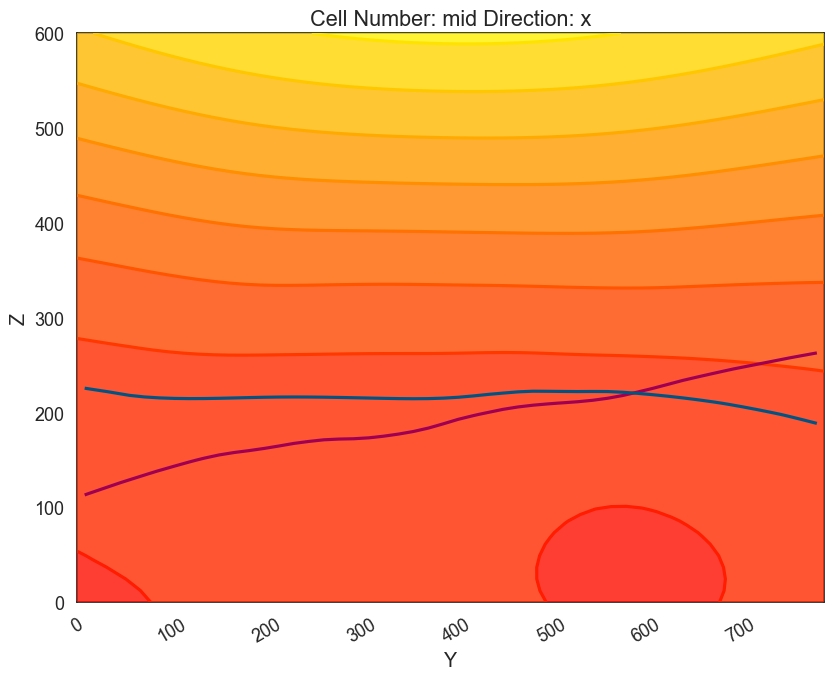

In [34]:
gp.plot_2d(geo_model, direction='x', show_data=False, show_scalar=True, show_lith=False)

<a id='visualizing-the-computed-model-in-3d'></a>

# Visualizing the computed model in 3D

The computed model can be visualized in 3D using the `pyvista` library. Setting `notebook=False` will open an interactive windows and the model can be rotated and zooming is possible. 

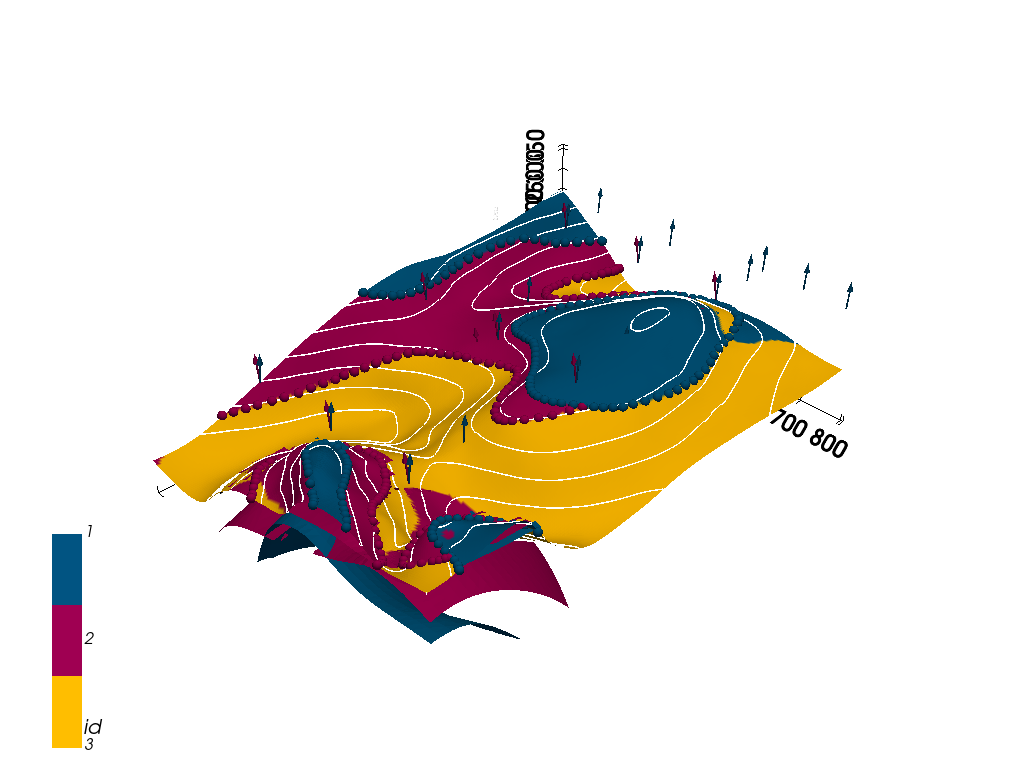

In [35]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=False)

<a id='conclusions'></a>
# Conclusions

<div class="alert alert-block alert-success">
<b>In this tutorial, you have learnt the following:</b> <br>
- How to build your 12th GemPy model with input data generated through GemGIS<br>
- How to create models consisting of unconformable layers

</div>

<a id='outlook'></a>
# Outlook

<div class="alert alert-block alert-success">
<b>In the next tutorial, you will learn the following:</b> <br>
- How to build your 13th GemPy model with input data generated through GemGIS<br>
- How to create models consisting of combined structural elements like fold and faults
</div>

[Take me to the next notebook on Github](https://github.com/cgre-aachen/gemgis_data/blob/main/notebooks/06_combined_models/example01_folded_unconformable_layers.ipynb)

<img src="../../data/images/example6/cover_example06.png" />
Source: Bennison, G.M. (1988): An Introduction to Geological Structures and Maps, page 24, figure 10, Springer Verlag Berlin, Heidelberg, New York, ISBN: 978-1-4615-9632-5

<a id='licensing'></a>

## Licensing

Institute for Computational Geoscience, Geothermics and Reservoir Geophysics, RWTH Aachen University & Fraunhofer IEG, Fraunhofer Research Institution for Energy Infrastructures and Geothermal Systems IEG, Authors: Alexander Juestel. For more information contact: alexander.juestel(at)ieg.fraunhofer.de

All notebooks are licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0, http://creativecommons.org/licenses/by/4.0/). References for each displayed map are provided. Most of the maps originate from the books of [Powell (1992)](https://link.springer.com/book/9783540586074) and [Bennison (1990)](https://link.springer.com/book/10.1007/978-1-4615-9630-1). References for maps with unknown origin will gladly be added.